In [1]:
import pandas as pd
import numpy as np
import h5py
import datetime
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import seaborn as sns
from scipy.signal import savgol_filter
plt.style.use('seaborn')

In [11]:
def get_calibration_temperature(file, calibration_path):
    with h5py.File(file, 'r') as h5_file:
        cal_temp = h5_file[calibration_path].attrs['ftir_temperature']
        return cal_temp
    
def get_insertion_temperature(file, insertion_path):
    with h5py.File(file, 'r') as h5_file:
        ins_temp = h5_file[insertion_path].attrs['ftir_temp']
        return ins_temp
    
def get_visible_white_calibration_curve(file, calibration_path):
    with h5py.File(file, 'r') as h5_file:
        cal = h5_file[calibration_path].attrs['white_spectrum'][:]
        return cal
    
def get_ftir_white_calibration_curve(file, calibration_path):
    with h5py.File(file, 'r') as h5_file:
        cal = h5_file[calibration_path].attrs['white_spectrum2'][:]
        return cal
    
def get_visible_wavelength_vector(file, calibration_path):
    with h5py.File(file, 'r') as h5_file:
        waves = h5_file[calibration_path].attrs['spec1_wavelengths_vector'][:]
        return waves
    
def get_ftir_wavelength_vector(file, calibration_path):
    with h5py.File(file, 'r') as h5_file:
        waves = h5_file[calibration_path].attrs['spec2_wavelengths_vector'][:]
        return waves
    
def get_ftir_insertion_absorbances(file, insertion_path):
    with h5py.File(file, 'r') as h5_file:
        ins_abs = h5_file[f'{insertion_path}/spectrometer2/derived/absorbances'][:]
        return ins_abs
    
def get_ftir_insertion_raw_spectra(file, insertion_path):
    with h5py.File(file, 'r') as h5_file:
        ins_raw = h5_file[f'{insertion_path}/spectrometer2/spectra'][:]
        return ins_raw
    
def get_visible_insertion_absorbances(file, insertion_path):
    with h5py.File(file, 'r') as h5_file:
        ins_abs = h5_file[f'{insertion_path}/spectrometer1/derived/absorbances'][:]
        return ins_abs
    
def get_visible_insertion_raw_spectra(file, insertion_path):
    with h5py.File(file, 'r') as h5_file:
        ins_raw = h5_file[f'{insertion_path}/spectrometer1/spectra'][:]
        return ins_raw
    
def create_list_of_items_in_node(item_type, file, node):
    with h5py.File(file, 'r') as h5_file:
        keys = []
        if item_type == "group":
            my_type = h5py._hl.group.Group
        if item_type == "dataset":
            my_type = h5py._hl.dataset.Dataset
        h5_file[node].visit(lambda key: keys.append(key) if type(h5_file[node][key]) is my_type else None)
        return keys

def create_list_of_calibrations_in_node(file, node):
    calibrations = []
    all_groups = create_list_of_items_in_node("group", file, node)
    for group in all_groups:
        if group[-6:-3] == 'cal':
            calibrations.append(group)
    return calibrations

def create_list_of_insertions_in_calibration(file, calibration_path):
    with h5py.File(file, 'r') as h5_file:
        insertions = list(h5_file[calibration_path].keys())
        return insertions
    
def select_by_depth_range(df, range_start, range_end):
    df_out = df.loc[(df['depth'] > range_start) & (df['depth'] < range_end)]
    return df_out

def calculate_absorbance_from_raw(raw_spectrum, white_spectrum, dark_spectrum):
    reflectance = ((raw_spectrum - dark_spectrum) / (white_spectrum - dark_spectrum))
    inverse_reflectance = 1/reflectance
    absorbance = np.log10(inverse_reflectance.astype(np.float64))
    return absorbance

def append_session_insertion_strings(insertion_list, session_string, insertion_min, insertion_max):
    for i in range(insertion_min, insertion_max + 1):
        string = f'{session_string}/ins{i:03d}'
        insertion_list.append(string)

In [3]:
path_name = "/Users/linda/OneDrive/Documents/S4_mine_p/Projects/Data_collected/"
test_file_name = '210423_green_tests/green_testing_210423.h5'
file = path_name + test_file_name

ses1_cals = create_list_of_calibrations_in_node(file, 'session001')

ses2_cals = create_list_of_calibrations_in_node(file, 'session002')

cals = []
for cal in ses1_cals:
    ses_cal = 'session001/' + cal
    cals.append(ses_cal)
for cal in ses2_cals:
    ses_cal = 'session002/' + cal
    cals.append(ses_cal)

In [4]:
ses1_cals

['cal001', 'cal002']

In [5]:
ses2_cals

['cal001', 'cal002', 'cal003', 'cal004']

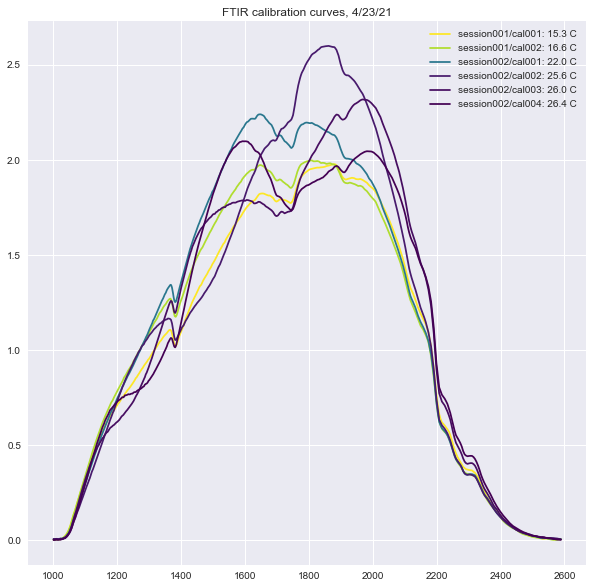

In [16]:
# get calibration curves
ftir_curves = []
for cal in cals:
    ftir_curve = get_ftir_white_calibration_curve(file, cal)
    ftir_curves.append(ftir_curve)
ftir_cal_temps = []

# get temperatures and find max and min temps
for cal in cals:
    ftir_temp = get_calibration_temperature(file, cal)
    ftir_cal_temps.append(ftir_temp)    
temp_max = max(ftir_cal_temps)
temp_min = min(ftir_cal_temps)

# get wavelengths vector
ftir_waves = get_ftir_wavelength_vector(file, cals[0])

# create plot
fig, ax = plt.subplots(figsize=(10,10))
ax.set_title("FTIR calibration curves, 4/23/21")
for calibration in cals:
    cal_temp = get_calibration_temperature(file, calibration)
    color = plt.cm.viridis((cal_temp - temp_max)/(temp_min - temp_max))
    ftir_cal = get_ftir_white_calibration_curve(file, calibration)
    ftir_waves = get_ftir_wavelength_vector(file, calibration)
    ax.plot(ftir_waves, ftir_cal, color=color, label=f'{calibration}: {cal_temp:0.1f} C')
ax.legend()
plt.show()
plt.close()

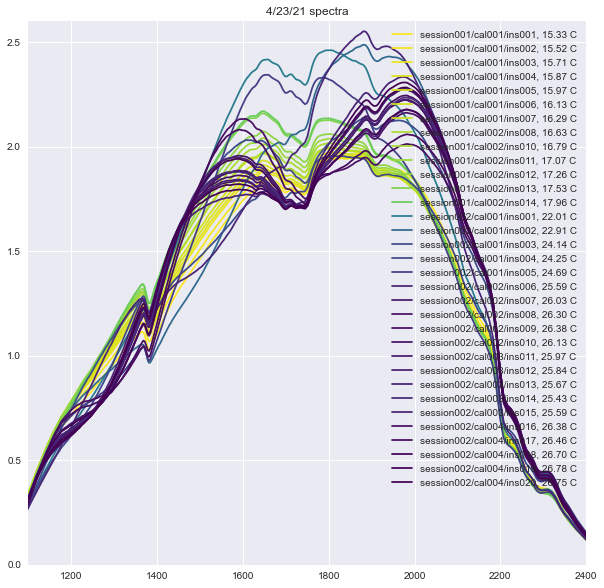

In [66]:
# compile a list of the insertions to plot
white_blank_ins = []
append_session_insertion_strings(white_blank_ins, 'session001/cal001', 1, 7)
append_session_insertion_strings(white_blank_ins, 'session001/cal002', 8, 8)
append_session_insertion_strings(white_blank_ins, 'session001/cal002', 10, 14)
append_session_insertion_strings(white_blank_ins, 'session002/cal001', 1, 5)
append_session_insertion_strings(white_blank_ins, 'session002/cal002', 6, 10)
append_session_insertion_strings(white_blank_ins, 'session002/cal003', 11, 15)
append_session_insertion_strings(white_blank_ins, 'session002/cal004', 16, 20)

# Get temperatures for the insertion and find min and max temps
insertion_temps = []
for insertion in white_blank_ins:    
    insertion_temp = get_insertion_temperature(file, insertion)
    insertion_temps.append(insertion_temp)
temp_min = min(insertion_temps)
temp_max = max(insertion_temps)

# plot raw means for each insertion, color determined by temperature
fig, ax = plt.subplots(figsize=(10, 10))
ax.set_xlim(1100, 2400)
ax.set_ylim(0.0, 2.6)
ax.set_title("4/23/21 spectra")

for insertion in white_blank_ins:    
    insertion_temp = get_insertion_temperature(file, insertion)
    color = plt.cm.viridis((insertion_temp - temp_max)/(temp_min - temp_max))
    ins_raw = get_ftir_insertion_raw_spectra(file, insertion)
    ftir_waves = get_ftir_wavelength_vector(file, calibration)
    ax.plot(ftir_waves, ins_raw.mean(axis=0), color=color, label=f'{insertion}, {insertion_temp:0.2f} C')
ax.legend()
plt.show()
plt.close()

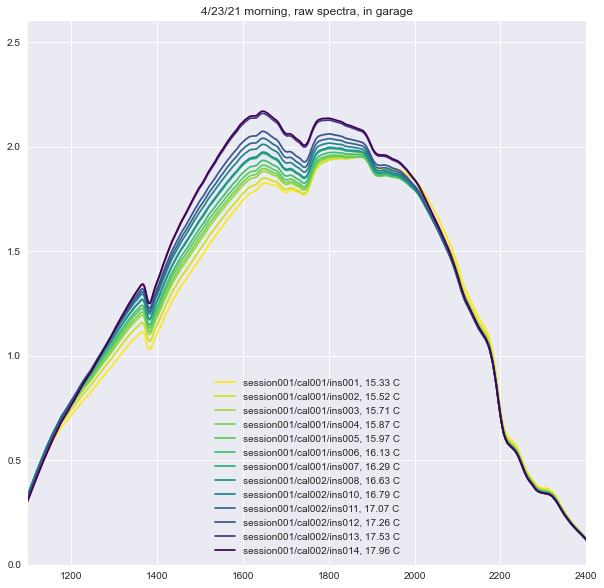

In [67]:
# compile a list of the insertions to plot
white_blank_ins = []
append_session_insertion_strings(white_blank_ins, 'session001/cal001', 1, 7)
append_session_insertion_strings(white_blank_ins, 'session001/cal002', 8, 8)
append_session_insertion_strings(white_blank_ins, 'session001/cal002', 10, 14)
# append_session_insertion_strings(white_blank_ins, 'session002/cal001', 1, 5)
# append_session_insertion_strings(white_blank_ins, 'session002/cal002', 6, 10)
# append_session_insertion_strings(white_blank_ins, 'session002/cal003', 11, 15)
# append_session_insertion_strings(white_blank_ins, 'session002/cal004', 16, 20)

# Get temperatures for the insertion and find min and max temps
insertion_temps = []
for insertion in white_blank_ins:    
    insertion_temp = get_insertion_temperature(file, insertion)
    insertion_temps.append(insertion_temp)
temp_min = min(insertion_temps)
temp_max = max(insertion_temps)

# plot raw means for each insertion, color determined by temperature
fig, ax = plt.subplots(figsize=(10, 10))
ax.set_xlim(1100, 2400)
ax.set_ylim(0.0, 2.6)
ax.set_title("4/23/21 morning, raw spectra, in garage")

for insertion in white_blank_ins:    
    insertion_temp = get_insertion_temperature(file, insertion)
    color = plt.cm.viridis((insertion_temp - temp_max)/(temp_min - temp_max))
    ins_raw = get_ftir_insertion_raw_spectra(file, insertion)
    ftir_waves = get_ftir_wavelength_vector(file, calibration)
    ax.plot(ftir_waves, ins_raw.mean(axis=0), color=color, label=f'{insertion}, {insertion_temp:0.2f} C')
ax.legend()
plt.show()
plt.close()

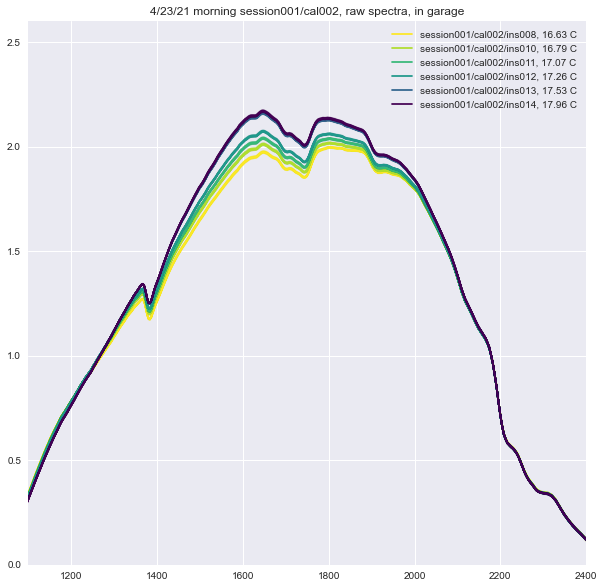

In [68]:
# compile a list of the insertions to plot
white_blank_ins = []
# append_session_insertion_strings(white_blank_ins, 'session001/cal001', 1, 7)
append_session_insertion_strings(white_blank_ins, 'session001/cal002', 8, 8)
append_session_insertion_strings(white_blank_ins, 'session001/cal002', 10, 14)
# append_session_insertion_strings(white_blank_ins, 'session002/cal001', 1, 5)
# append_session_insertion_strings(white_blank_ins, 'session002/cal002', 6, 10)
# append_session_insertion_strings(white_blank_ins, 'session002/cal003', 11, 15)
# append_session_insertion_strings(white_blank_ins, 'session002/cal004', 16, 20)

# Get temperatures for the insertion and find min and max temps
insertion_temps = []
for insertion in white_blank_ins:    
    insertion_temp = get_insertion_temperature(file, insertion)
    insertion_temps.append(insertion_temp)
temp_min = min(insertion_temps)
temp_max = max(insertion_temps)

# plot raw means for each insertion, color determined by temperature
fig, ax = plt.subplots(figsize=(10, 10))
ax.set_xlim(1100, 2400)
ax.set_ylim(0.0, 2.6)
ax.set_title("4/23/21 morning session001/cal002, raw spectra, in garage")

for insertion in white_blank_ins:    
    insertion_temp = get_insertion_temperature(file, insertion)
    color = plt.cm.viridis((insertion_temp - temp_max)/(temp_min - temp_max))
    ins_raw = get_ftir_insertion_raw_spectra(file, insertion)
    ftir_waves = get_ftir_wavelength_vector(file, calibration)
    ax.plot(ftir_waves, ins_raw.mean(axis=0), color=color, label=f'{insertion}, {insertion_temp:0.2f} C')
    for i in range(ins_raw.shape[0]):
        ax.plot(ftir_waves, ins_raw[i, :], color=color, alpha=0.1)
ax.legend()
plt.show()
plt.close()

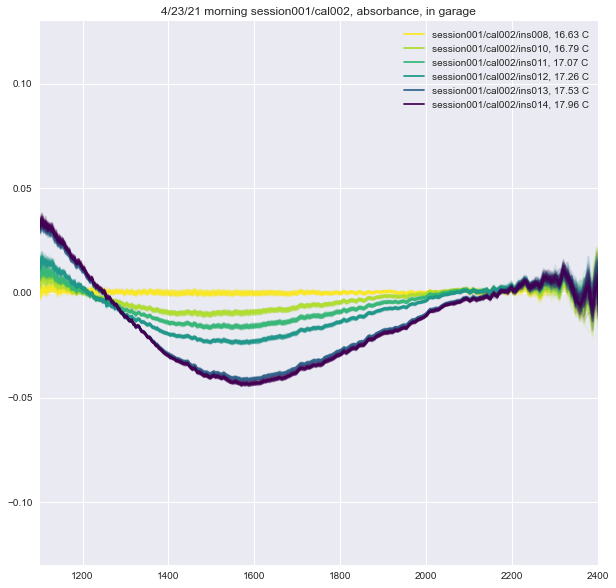

In [70]:
# compile a list of the insertions to plot
white_blank_ins = []
# append_session_insertion_strings(white_blank_ins, 'session001/cal001', 1, 7)
append_session_insertion_strings(white_blank_ins, 'session001/cal002', 8, 8)
append_session_insertion_strings(white_blank_ins, 'session001/cal002', 10, 14)
# append_session_insertion_strings(white_blank_ins, 'session002/cal001', 1, 5)
# append_session_insertion_strings(white_blank_ins, 'session002/cal002', 6, 10)
# append_session_insertion_strings(white_blank_ins, 'session002/cal003', 11, 15)
# append_session_insertion_strings(white_blank_ins, 'session002/cal004', 16, 20)

# Get temperatures for the insertion and find min and max temps
insertion_temps = []
for insertion in white_blank_ins:    
    insertion_temp = get_insertion_temperature(file, insertion)
    insertion_temps.append(insertion_temp)
temp_min = min(insertion_temps)
temp_max = max(insertion_temps)

# plot raw means for each insertion, color determined by temperature
fig, ax = plt.subplots(figsize=(10, 10))
ax.set_xlim(1100, 2400)
ax.set_ylim(-0.13, 0.13)
ax.set_title("4/23/21 morning session001/cal002, absorbance, in garage")

for insertion in white_blank_ins:    
    insertion_temp = get_insertion_temperature(file, insertion)
    color = plt.cm.viridis((insertion_temp - temp_max)/(temp_min - temp_max))
    ins_raw = get_ftir_insertion_absorbances(file, insertion)
    ftir_waves = get_ftir_wavelength_vector(file, calibration)
    ax.plot(ftir_waves, ins_raw.mean(axis=0), color=color, label=f'{insertion}, {insertion_temp:0.2f} C')
    for i in range(ins_raw.shape[0]):
        ax.plot(ftir_waves, ins_raw[i, :], color=color, alpha=0.1)
ax.legend()
plt.show()
plt.close()

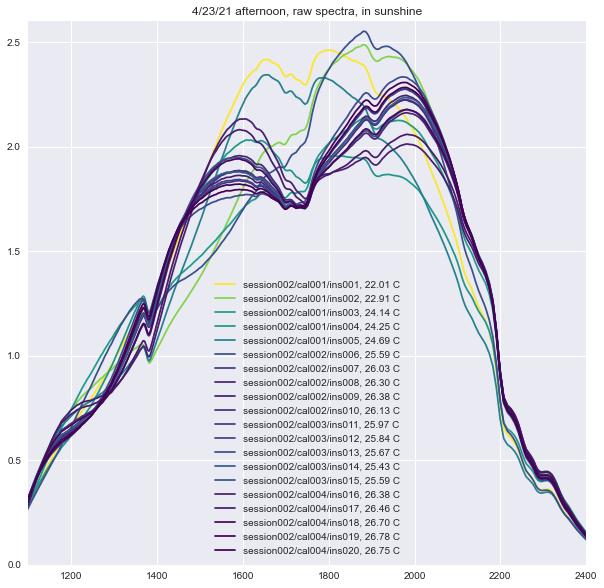

In [71]:
# compile a list of the insertions to plot
white_blank_ins = []
# append_session_insertion_strings(white_blank_ins, 'session001/cal001', 1, 7)
# append_session_insertion_strings(white_blank_ins, 'session001/cal002', 8, 8)
# append_session_insertion_strings(white_blank_ins, 'session001/cal002', 10, 14)
append_session_insertion_strings(white_blank_ins, 'session002/cal001', 1, 5)
append_session_insertion_strings(white_blank_ins, 'session002/cal002', 6, 10)
append_session_insertion_strings(white_blank_ins, 'session002/cal003', 11, 15)
append_session_insertion_strings(white_blank_ins, 'session002/cal004', 16, 20)

# Get temperatures for the insertion and find min and max temps
insertion_temps = []
for insertion in white_blank_ins:    
    insertion_temp = get_insertion_temperature(file, insertion)
    insertion_temps.append(insertion_temp)
temp_min = min(insertion_temps)
temp_max = max(insertion_temps)

# plot raw means for each insertion, color determined by temperature
fig, ax = plt.subplots(figsize=(10, 10))
ax.set_xlim(1100, 2400)
ax.set_ylim(0.0, 2.6)
ax.set_title("4/23/21 afternoon, raw spectra, in sunshine")

for insertion in white_blank_ins:    
    insertion_temp = get_insertion_temperature(file, insertion)
    color = plt.cm.viridis((insertion_temp - temp_max)/(temp_min - temp_max))
    ins_raw = get_ftir_insertion_raw_spectra(file, insertion)
    ftir_waves = get_ftir_wavelength_vector(file, calibration)
    ax.plot(ftir_waves, ins_raw.mean(axis=0), color=color, label=f'{insertion}, {insertion_temp:0.2f} C')
ax.legend()
plt.show()
plt.close()

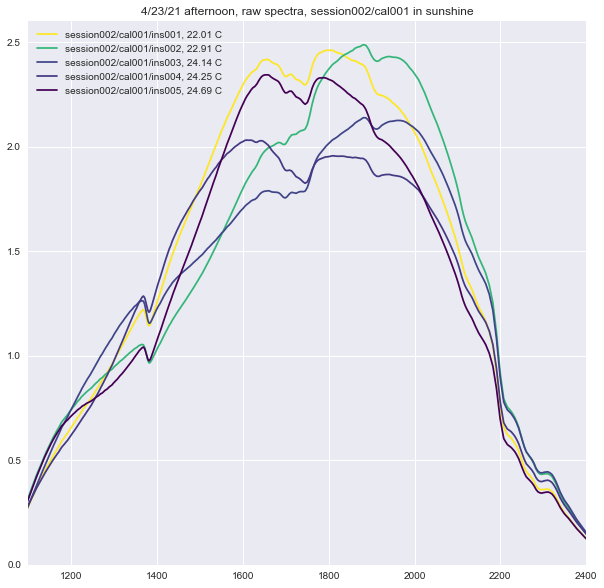

In [72]:
# compile a list of the insertions to plot
white_blank_ins = []
# append_session_insertion_strings(white_blank_ins, 'session001/cal001', 1, 7)
# append_session_insertion_strings(white_blank_ins, 'session001/cal002', 8, 8)
# append_session_insertion_strings(white_blank_ins, 'session001/cal002', 10, 14)
append_session_insertion_strings(white_blank_ins, 'session002/cal001', 1, 5)
# append_session_insertion_strings(white_blank_ins, 'session002/cal002', 6, 10)
# append_session_insertion_strings(white_blank_ins, 'session002/cal003', 11, 15)
# append_session_insertion_strings(white_blank_ins, 'session002/cal004', 16, 20)

# Get temperatures for the insertion and find min and max temps
insertion_temps = []
for insertion in white_blank_ins:    
    insertion_temp = get_insertion_temperature(file, insertion)
    insertion_temps.append(insertion_temp)
temp_min = min(insertion_temps)
temp_max = max(insertion_temps)

# plot raw means for each insertion, color determined by temperature
fig, ax = plt.subplots(figsize=(10, 10))
ax.set_xlim(1100, 2400)
ax.set_ylim(0.0, 2.6)
ax.set_title("4/23/21 afternoon, raw spectra, session002/cal001 in sunshine")

for insertion in white_blank_ins:    
    insertion_temp = get_insertion_temperature(file, insertion)
    color = plt.cm.viridis((insertion_temp - temp_max)/(temp_min - temp_max))
    ins_raw = get_ftir_insertion_raw_spectra(file, insertion)
    ftir_waves = get_ftir_wavelength_vector(file, calibration)
    ax.plot(ftir_waves, ins_raw.mean(axis=0), color=color, label=f'{insertion}, {insertion_temp:0.2f} C')
ax.legend()
plt.show()
plt.close()

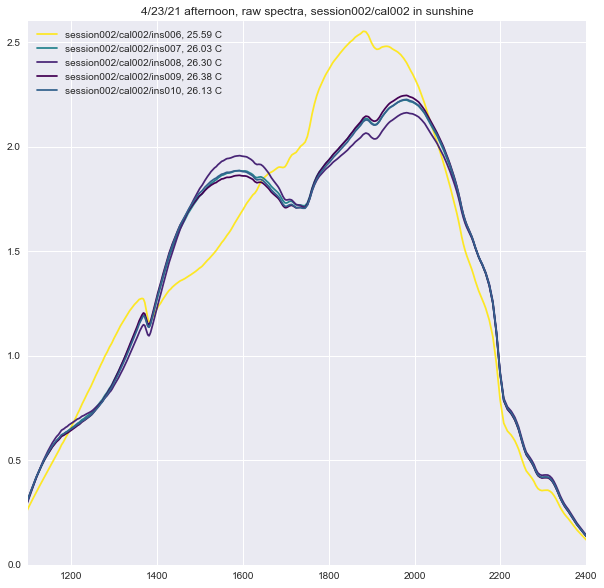

In [73]:
# compile a list of the insertions to plot
white_blank_ins = []
# append_session_insertion_strings(white_blank_ins, 'session001/cal001', 1, 7)
# append_session_insertion_strings(white_blank_ins, 'session001/cal002', 8, 8)
# append_session_insertion_strings(white_blank_ins, 'session001/cal002', 10, 14)
# append_session_insertion_strings(white_blank_ins, 'session002/cal001', 1, 5)
append_session_insertion_strings(white_blank_ins, 'session002/cal002', 6, 10)
# append_session_insertion_strings(white_blank_ins, 'session002/cal003', 11, 15)
# append_session_insertion_strings(white_blank_ins, 'session002/cal004', 16, 20)

# Get temperatures for the insertion and find min and max temps
insertion_temps = []
for insertion in white_blank_ins:    
    insertion_temp = get_insertion_temperature(file, insertion)
    insertion_temps.append(insertion_temp)
temp_min = min(insertion_temps)
temp_max = max(insertion_temps)

# plot raw means for each insertion, color determined by temperature
fig, ax = plt.subplots(figsize=(10, 10))
ax.set_xlim(1100, 2400)
ax.set_ylim(0.0, 2.6)
ax.set_title("4/23/21 afternoon, raw spectra, session002/cal002 in sunshine")

for insertion in white_blank_ins:    
    insertion_temp = get_insertion_temperature(file, insertion)
    color = plt.cm.viridis((insertion_temp - temp_max)/(temp_min - temp_max))
    ins_raw = get_ftir_insertion_raw_spectra(file, insertion)
    ftir_waves = get_ftir_wavelength_vector(file, calibration)
    ax.plot(ftir_waves, ins_raw.mean(axis=0), color=color, label=f'{insertion}, {insertion_temp:0.2f} C')
ax.legend()
plt.show()
plt.close()

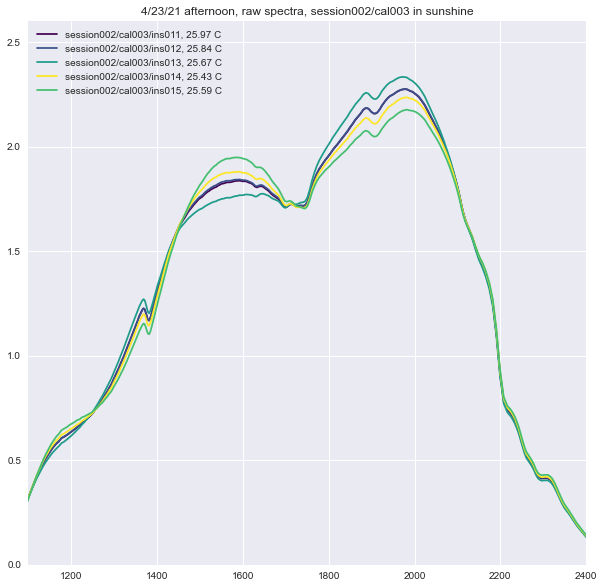

In [74]:
# compile a list of the insertions to plot
white_blank_ins = []
# append_session_insertion_strings(white_blank_ins, 'session001/cal001', 1, 7)
# append_session_insertion_strings(white_blank_ins, 'session001/cal002', 8, 8)
# append_session_insertion_strings(white_blank_ins, 'session001/cal002', 10, 14)
# append_session_insertion_strings(white_blank_ins, 'session002/cal001', 1, 5)
# append_session_insertion_strings(white_blank_ins, 'session002/cal002', 6, 10)
append_session_insertion_strings(white_blank_ins, 'session002/cal003', 11, 15)
# append_session_insertion_strings(white_blank_ins, 'session002/cal004', 16, 20)

# Get temperatures for the insertion and find min and max temps
insertion_temps = []
for insertion in white_blank_ins:    
    insertion_temp = get_insertion_temperature(file, insertion)
    insertion_temps.append(insertion_temp)
temp_min = min(insertion_temps)
temp_max = max(insertion_temps)

# plot raw means for each insertion, color determined by temperature
fig, ax = plt.subplots(figsize=(10, 10))
ax.set_xlim(1100, 2400)
ax.set_ylim(0.0, 2.6)
ax.set_title("4/23/21 afternoon, raw spectra, session002/cal003 in sunshine")

for insertion in white_blank_ins:    
    insertion_temp = get_insertion_temperature(file, insertion)
    color = plt.cm.viridis((insertion_temp - temp_max)/(temp_min - temp_max))
    ins_raw = get_ftir_insertion_raw_spectra(file, insertion)
    ftir_waves = get_ftir_wavelength_vector(file, calibration)
    ax.plot(ftir_waves, ins_raw.mean(axis=0), color=color, label=f'{insertion}, {insertion_temp:0.2f} C')
ax.legend()
plt.show()
plt.close()

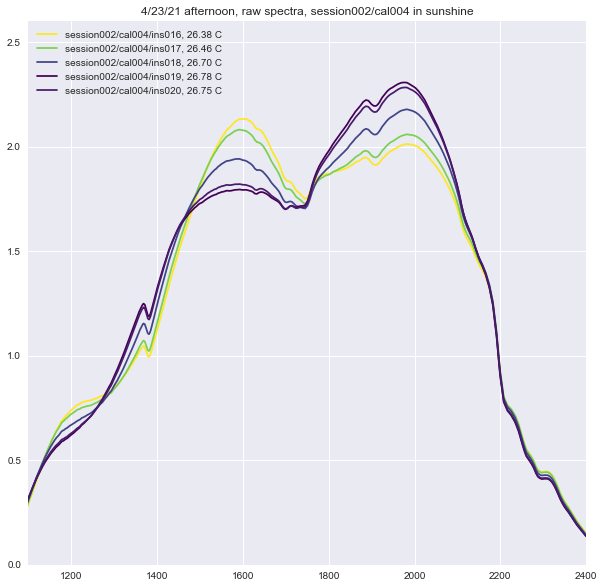

In [75]:
# compile a list of the insertions to plot
white_blank_ins = []
# append_session_insertion_strings(white_blank_ins, 'session001/cal001', 1, 7)
# append_session_insertion_strings(white_blank_ins, 'session001/cal002', 8, 8)
# append_session_insertion_strings(white_blank_ins, 'session001/cal002', 10, 14)
# append_session_insertion_strings(white_blank_ins, 'session002/cal001', 1, 5)
# append_session_insertion_strings(white_blank_ins, 'session002/cal002', 6, 10)
# append_session_insertion_strings(white_blank_ins, 'session002/cal003', 11, 15)
append_session_insertion_strings(white_blank_ins, 'session002/cal004', 16, 20)

# Get temperatures for the insertion and find min and max temps
insertion_temps = []
for insertion in white_blank_ins:    
    insertion_temp = get_insertion_temperature(file, insertion)
    insertion_temps.append(insertion_temp)
temp_min = min(insertion_temps)
temp_max = max(insertion_temps)

# plot raw means for each insertion, color determined by temperature
fig, ax = plt.subplots(figsize=(10, 10))
ax.set_xlim(1100, 2400)
ax.set_ylim(0.0, 2.6)
ax.set_title("4/23/21 afternoon, raw spectra, session002/cal004 in sunshine")

for insertion in white_blank_ins:    
    insertion_temp = get_insertion_temperature(file, insertion)
    color = plt.cm.viridis((insertion_temp - temp_max)/(temp_min - temp_max))
    ins_raw = get_ftir_insertion_raw_spectra(file, insertion)
    ftir_waves = get_ftir_wavelength_vector(file, calibration)
    ax.plot(ftir_waves, ins_raw.mean(axis=0), color=color, label=f'{insertion}, {insertion_temp:0.2f} C')
ax.legend()
plt.show()
plt.close()

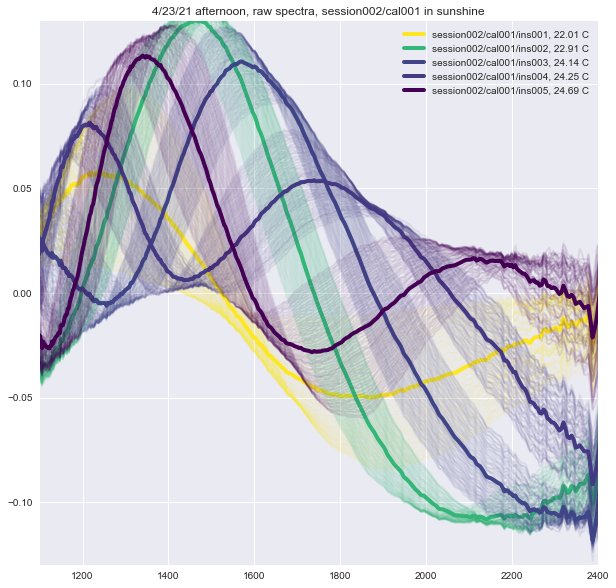

In [76]:
# compile a list of the insertions to plot
white_blank_ins = []
# append_session_insertion_strings(white_blank_ins, 'session001/cal001', 1, 7)
# append_session_insertion_strings(white_blank_ins, 'session001/cal002', 8, 8)
# append_session_insertion_strings(white_blank_ins, 'session001/cal002', 10, 14)
append_session_insertion_strings(white_blank_ins, 'session002/cal001', 1, 5)
# append_session_insertion_strings(white_blank_ins, 'session002/cal002', 6, 10)
# append_session_insertion_strings(white_blank_ins, 'session002/cal003', 11, 15)
# append_session_insertion_strings(white_blank_ins, 'session002/cal004', 16, 20)

# Get temperatures for the insertion and find min and max temps
insertion_temps = []
for insertion in white_blank_ins:    
    insertion_temp = get_insertion_temperature(file, insertion)
    insertion_temps.append(insertion_temp)
temp_min = min(insertion_temps)
temp_max = max(insertion_temps)

# plot raw means for each insertion, color determined by temperature
fig, ax = plt.subplots(figsize=(10, 10))
ax.set_xlim(1100, 2400)
ax.set_ylim(-0.13, 0.13)
ax.set_title("4/23/21 afternoon, raw spectra, session002/cal001 in sunshine")

for insertion in white_blank_ins:    
    insertion_temp = get_insertion_temperature(file, insertion)
    color = plt.cm.viridis((insertion_temp - temp_max)/(temp_min - temp_max))
    ins_raw = get_ftir_insertion_absorbances(file, insertion)
    ftir_waves = get_ftir_wavelength_vector(file, calibration)
    ax.plot(ftir_waves, ins_raw.mean(axis=0), color=color, lw=4, label=f'{insertion}, {insertion_temp:0.2f} C')
    for i in range(ins_raw.shape[0]):
        ax.plot(ftir_waves, ins_raw[i, :], color=color, alpha=0.1)
ax.legend()
plt.show()
plt.close()

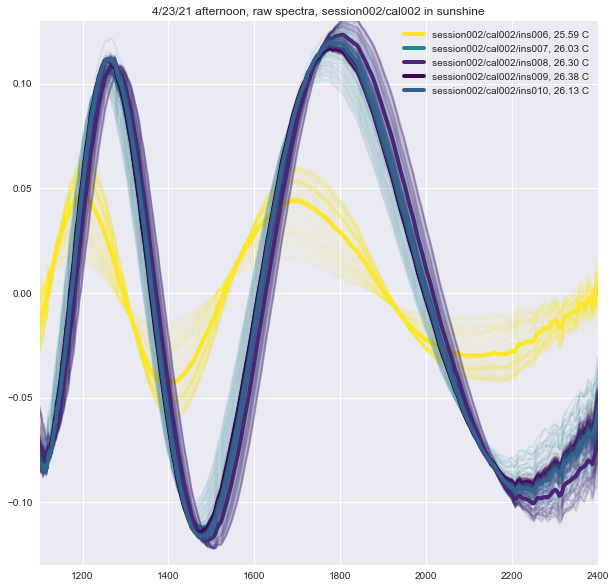

In [78]:
# compile a list of the insertions to plot
white_blank_ins = []
# append_session_insertion_strings(white_blank_ins, 'session001/cal001', 1, 7)
# append_session_insertion_strings(white_blank_ins, 'session001/cal002', 8, 8)
# append_session_insertion_strings(white_blank_ins, 'session001/cal002', 10, 14)
# append_session_insertion_strings(white_blank_ins, 'session002/cal001', 1, 5)
append_session_insertion_strings(white_blank_ins, 'session002/cal002', 6, 10)
# append_session_insertion_strings(white_blank_ins, 'session002/cal003', 11, 15)
# append_session_insertion_strings(white_blank_ins, 'session002/cal004', 16, 20)

# Get temperatures for the insertion and find min and max temps
insertion_temps = []
for insertion in white_blank_ins:    
    insertion_temp = get_insertion_temperature(file, insertion)
    insertion_temps.append(insertion_temp)
temp_min = min(insertion_temps)
temp_max = max(insertion_temps)

# plot raw means for each insertion, color determined by temperature
fig, ax = plt.subplots(figsize=(10, 10))
ax.set_xlim(1100, 2400)
ax.set_ylim(-0.13, 0.13)
ax.set_title("4/23/21 afternoon, raw spectra, session002/cal002 in sunshine")

for insertion in white_blank_ins:    
    insertion_temp = get_insertion_temperature(file, insertion)
    color = plt.cm.viridis((insertion_temp - temp_max)/(temp_min - temp_max))
    ins_raw = get_ftir_insertion_absorbances(file, insertion)
    ftir_waves = get_ftir_wavelength_vector(file, calibration)
    ax.plot(ftir_waves, ins_raw.mean(axis=0), color=color, lw=4, label=f'{insertion}, {insertion_temp:0.2f} C')
    for i in range(ins_raw.shape[0]):
        ax.plot(ftir_waves, ins_raw[i, :], color=color, alpha=0.1)
ax.legend()
plt.show()
plt.close()

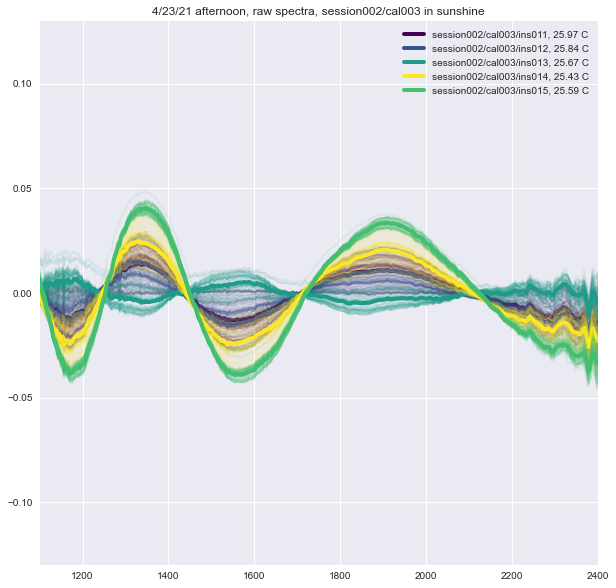

In [79]:
# compile a list of the insertions to plot
white_blank_ins = []
# append_session_insertion_strings(white_blank_ins, 'session001/cal001', 1, 7)
# append_session_insertion_strings(white_blank_ins, 'session001/cal002', 8, 8)
# append_session_insertion_strings(white_blank_ins, 'session001/cal002', 10, 14)
# append_session_insertion_strings(white_blank_ins, 'session002/cal001', 1, 5)
# append_session_insertion_strings(white_blank_ins, 'session002/cal002', 6, 10)
append_session_insertion_strings(white_blank_ins, 'session002/cal003', 11, 15)
# append_session_insertion_strings(white_blank_ins, 'session002/cal004', 16, 20)

# Get temperatures for the insertion and find min and max temps
insertion_temps = []
for insertion in white_blank_ins:    
    insertion_temp = get_insertion_temperature(file, insertion)
    insertion_temps.append(insertion_temp)
temp_min = min(insertion_temps)
temp_max = max(insertion_temps)

# plot raw means for each insertion, color determined by temperature
fig, ax = plt.subplots(figsize=(10, 10))
ax.set_xlim(1100, 2400)
ax.set_ylim(-0.13, 0.13)
ax.set_title("4/23/21 afternoon, raw spectra, session002/cal003 in sunshine")

for insertion in white_blank_ins:    
    insertion_temp = get_insertion_temperature(file, insertion)
    color = plt.cm.viridis((insertion_temp - temp_max)/(temp_min - temp_max))
    ins_raw = get_ftir_insertion_absorbances(file, insertion)
    ftir_waves = get_ftir_wavelength_vector(file, calibration)
    ax.plot(ftir_waves, ins_raw.mean(axis=0), color=color, lw=4, label=f'{insertion}, {insertion_temp:0.2f} C')
    for i in range(ins_raw.shape[0]):
        ax.plot(ftir_waves, ins_raw[i, :], color=color, alpha=0.1)
ax.legend()
plt.show()
plt.close()

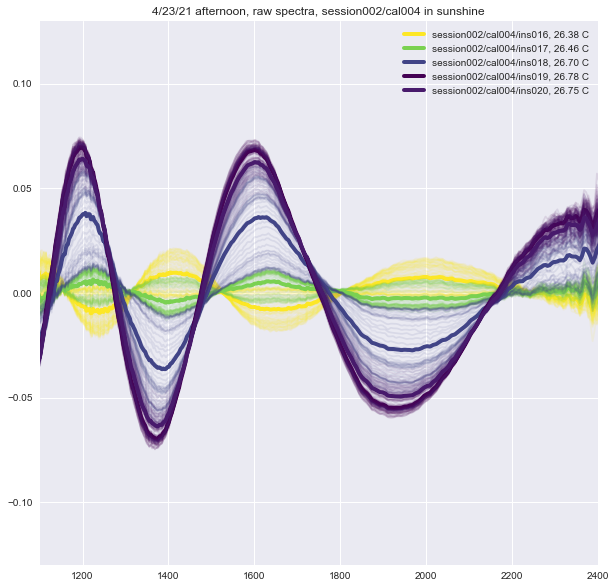

In [80]:
# compile a list of the insertions to plot
white_blank_ins = []
# append_session_insertion_strings(white_blank_ins, 'session001/cal001', 1, 7)
# append_session_insertion_strings(white_blank_ins, 'session001/cal002', 8, 8)
# append_session_insertion_strings(white_blank_ins, 'session001/cal002', 10, 14)
# append_session_insertion_strings(white_blank_ins, 'session002/cal001', 1, 5)
# append_session_insertion_strings(white_blank_ins, 'session002/cal002', 6, 10)
# append_session_insertion_strings(white_blank_ins, 'session002/cal003', 11, 15)
append_session_insertion_strings(white_blank_ins, 'session002/cal004', 16, 20)

# Get temperatures for the insertion and find min and max temps
insertion_temps = []
for insertion in white_blank_ins:    
    insertion_temp = get_insertion_temperature(file, insertion)
    insertion_temps.append(insertion_temp)
temp_min = min(insertion_temps)
temp_max = max(insertion_temps)

# plot raw means for each insertion, color determined by temperature
fig, ax = plt.subplots(figsize=(10, 10))
ax.set_xlim(1100, 2400)
ax.set_ylim(-0.13, 0.13)
ax.set_title("4/23/21 afternoon, raw spectra, session002/cal004 in sunshine")

for insertion in white_blank_ins:    
    insertion_temp = get_insertion_temperature(file, insertion)
    color = plt.cm.viridis((insertion_temp - temp_max)/(temp_min - temp_max))
    ins_raw = get_ftir_insertion_absorbances(file, insertion)
    ftir_waves = get_ftir_wavelength_vector(file, calibration)
    ax.plot(ftir_waves, ins_raw.mean(axis=0), color=color, lw=4, label=f'{insertion}, {insertion_temp:0.2f} C')
    for i in range(ins_raw.shape[0]):
        ax.plot(ftir_waves, ins_raw[i, :], color=color, alpha=0.1)
ax.legend()
plt.show()
plt.close()

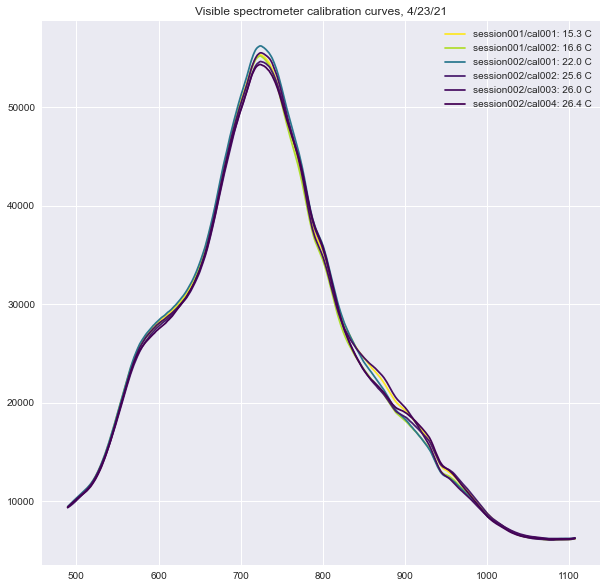

In [49]:
# get calibration curves
ftir_curves = []
for cal in cals:
    ftir_curve = get_visible_white_calibration_curve(file, cal)
    ftir_curves.append(ftir_curve)
ftir_cal_temps = []

# get temperatures and find max and min temps
for cal in cals:
    ftir_temp = get_calibration_temperature(file, cal)
    ftir_cal_temps.append(ftir_temp)    
temp_max = max(ftir_cal_temps)
temp_min = min(ftir_cal_temps)

# get wavelengths vector
ftir_waves = get_visible_wavelength_vector(file, cals[0])

# create plot
fig, ax = plt.subplots(figsize=(10,10))
ax.set_title("Visible spectrometer calibration curves, 4/23/21")
for calibration in cals:
    cal_temp = get_calibration_temperature(file, calibration)
    color = plt.cm.viridis((cal_temp - temp_max)/(temp_min - temp_max))
    ftir_cal = get_visible_white_calibration_curve(file, calibration)
    ftir_waves = get_visible_wavelength_vector(file, calibration)
    ax.plot(ftir_waves, savgol_filter(ftir_cal, 21, 3), color=color, label=f'{calibration}: {cal_temp:0.1f} C')
ax.legend()
plt.show()
plt.close()

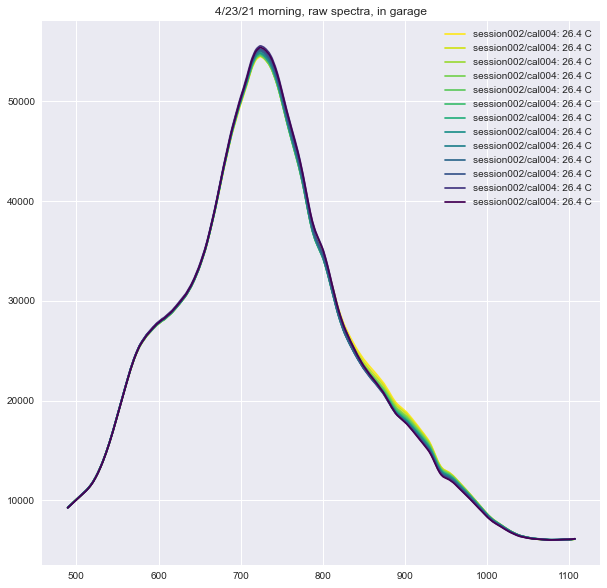

In [52]:
# compile a list of the insertions to plot
white_blank_ins = []
append_session_insertion_strings(white_blank_ins, 'session001/cal001', 1, 7)
append_session_insertion_strings(white_blank_ins, 'session001/cal002', 8, 8)
append_session_insertion_strings(white_blank_ins, 'session001/cal002', 10, 14)
# append_session_insertion_strings(white_blank_ins, 'session002/cal001', 1, 5)
# append_session_insertion_strings(white_blank_ins, 'session002/cal002', 6, 10)
# append_session_insertion_strings(white_blank_ins, 'session002/cal003', 11, 15)
# append_session_insertion_strings(white_blank_ins, 'session002/cal004', 16, 20)

# Get temperatures for the insertion and find min and max temps
insertion_temps = []
for insertion in white_blank_ins:    
    insertion_temp = get_insertion_temperature(file, insertion)
    insertion_temps.append(insertion_temp)
temp_min = min(insertion_temps)
temp_max = max(insertion_temps)

# plot raw means for each insertion, color determined by temperature
fig, ax = plt.subplots(figsize=(10, 10))
# ax.set_xlim(1100, 2400)
# ax.set_ylim(0.0, 2.6)
ax.set_title("4/23/21 morning, raw spectra, in garage")

for insertion in white_blank_ins:    
    insertion_temp = get_insertion_temperature(file, insertion)
    color = plt.cm.viridis((insertion_temp - temp_max)/(temp_min - temp_max))
    ins_raw = get_visible_insertion_raw_spectra(file, insertion)
    ftir_waves = get_visible_wavelength_vector(file, calibration)
    ax.plot(ftir_waves, savgol_filter(ins_raw.mean(axis=0), 21, 3), color=color, label=f'{calibration}: {cal_temp:0.1f} C')
ax.legend()
plt.show()
plt.close()

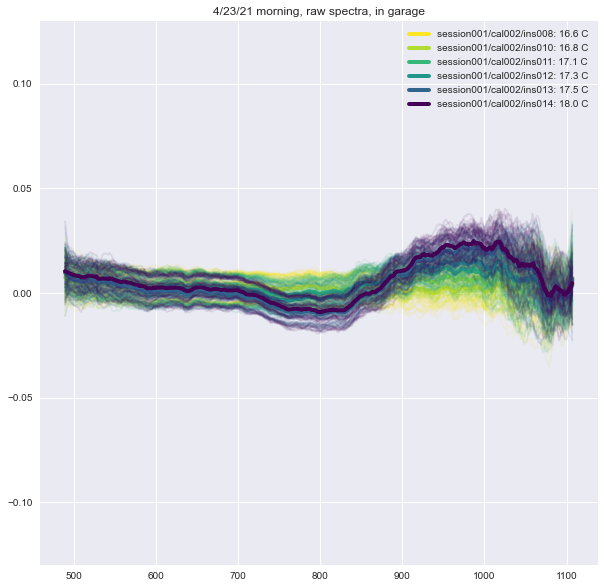

In [81]:
# compile a list of the insertions to plot
white_blank_ins = []
# append_session_insertion_strings(white_blank_ins, 'session001/cal001', 1, 7)
append_session_insertion_strings(white_blank_ins, 'session001/cal002', 8, 8)
append_session_insertion_strings(white_blank_ins, 'session001/cal002', 10, 14)
# append_session_insertion_strings(white_blank_ins, 'session002/cal001', 1, 5)
# append_session_insertion_strings(white_blank_ins, 'session002/cal002', 6, 10)
# append_session_insertion_strings(white_blank_ins, 'session002/cal003', 11, 15)
# append_session_insertion_strings(white_blank_ins, 'session002/cal004', 16, 20)

# Get temperatures for the insertion and find min and max temps
insertion_temps = []
for insertion in white_blank_ins:    
    insertion_temp = get_insertion_temperature(file, insertion)
    insertion_temps.append(insertion_temp)
temp_min = min(insertion_temps)
temp_max = max(insertion_temps)

# plot raw means for each insertion, color determined by temperature
fig, ax = plt.subplots(figsize=(10, 10))
# ax.set_xlim(1100, 2400)
ax.set_ylim(-0.13, 0.13)
ax.set_title("4/23/21 morning, raw spectra, in garage")

for insertion in white_blank_ins:    
    insertion_temp = get_insertion_temperature(file, insertion)
    color = plt.cm.viridis((insertion_temp - temp_max)/(temp_min - temp_max))
    ins_raw = get_visible_insertion_absorbances(file, insertion)
    ftir_waves = get_visible_wavelength_vector(file, calibration)
    ax.plot(ftir_waves, savgol_filter(ins_raw.mean(axis=0), 21, 3), color=color, lw=4, label=f'{insertion}: {insertion_temp:0.1f} C')
    for i in range(ins_raw.shape[0]):
        ax.plot(ftir_waves, savgol_filter(ins_raw[i, :], 21, 3), color=color, alpha=0.1)
ax.legend()
plt.show()
plt.close()

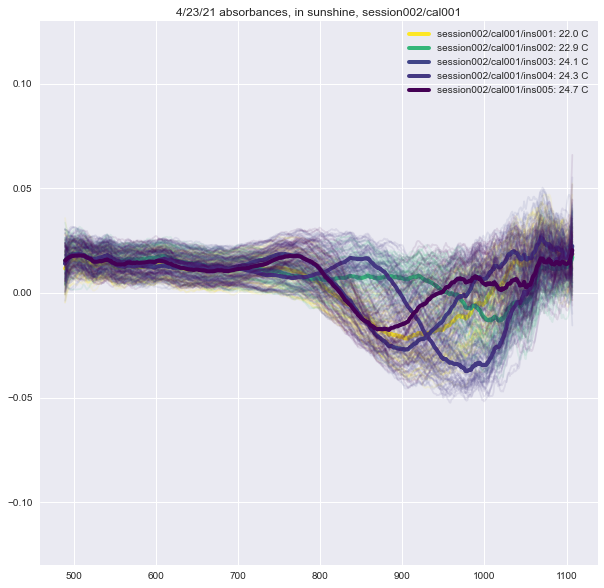

In [82]:
# compile a list of the insertions to plot
white_blank_ins = []
# append_session_insertion_strings(white_blank_ins, 'session001/cal001', 1, 7)
# append_session_insertion_strings(white_blank_ins, 'session001/cal002', 8, 8)
# append_session_insertion_strings(white_blank_ins, 'session001/cal002', 10, 14)
append_session_insertion_strings(white_blank_ins, 'session002/cal001', 1, 5)
# append_session_insertion_strings(white_blank_ins, 'session002/cal002', 6, 10)
# append_session_insertion_strings(white_blank_ins, 'session002/cal003', 11, 15)
# append_session_insertion_strings(white_blank_ins, 'session002/cal004', 16, 20)

# Get temperatures for the insertion and find min and max temps
insertion_temps = []
for insertion in white_blank_ins:    
    insertion_temp = get_insertion_temperature(file, insertion)
    insertion_temps.append(insertion_temp)
temp_min = min(insertion_temps)
temp_max = max(insertion_temps)

# plot raw means for each insertion, color determined by temperature
fig, ax = plt.subplots(figsize=(10, 10))
# ax.set_xlim(1100, 2400)
ax.set_ylim(-0.13, 0.13)
ax.set_title("4/23/21 absorbances, in sunshine, session002/cal001")

for insertion in white_blank_ins:    
    insertion_temp = get_insertion_temperature(file, insertion)
    color = plt.cm.viridis((insertion_temp - temp_max)/(temp_min - temp_max))
    ins_raw = get_visible_insertion_absorbances(file, insertion)
    ftir_waves = get_visible_wavelength_vector(file, calibration)
    ax.plot(ftir_waves, savgol_filter(ins_raw.mean(axis=0), 21, 3), color=color, lw=4, label=f'{insertion}: {insertion_temp:0.1f} C')
    for i in range(ins_raw.shape[0]):
        ax.plot(ftir_waves, savgol_filter(ins_raw[i, :], 21, 3), color=color, alpha=0.1)
ax.legend()
plt.show()
plt.close()

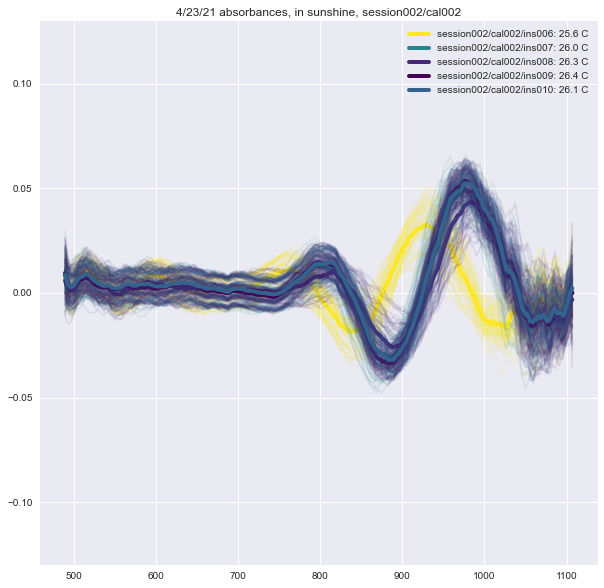

In [83]:
# compile a list of the insertions to plot
white_blank_ins = []
# append_session_insertion_strings(white_blank_ins, 'session001/cal001', 1, 7)
# append_session_insertion_strings(white_blank_ins, 'session001/cal002', 8, 8)
# append_session_insertion_strings(white_blank_ins, 'session001/cal002', 10, 14)
# append_session_insertion_strings(white_blank_ins, 'session002/cal001', 1, 5)
append_session_insertion_strings(white_blank_ins, 'session002/cal002', 6, 10)
# append_session_insertion_strings(white_blank_ins, 'session002/cal003', 11, 15)
# append_session_insertion_strings(white_blank_ins, 'session002/cal004', 16, 20)

# Get temperatures for the insertion and find min and max temps
insertion_temps = []
for insertion in white_blank_ins:    
    insertion_temp = get_insertion_temperature(file, insertion)
    insertion_temps.append(insertion_temp)
temp_min = min(insertion_temps)
temp_max = max(insertion_temps)

# plot raw means for each insertion, color determined by temperature
fig, ax = plt.subplots(figsize=(10, 10))
# ax.set_xlim(1100, 2400)
ax.set_ylim(-0.13, 0.13)
ax.set_title("4/23/21 absorbances, in sunshine, session002/cal002")

for insertion in white_blank_ins:    
    insertion_temp = get_insertion_temperature(file, insertion)
    color = plt.cm.viridis((insertion_temp - temp_max)/(temp_min - temp_max))
    ins_raw = get_visible_insertion_absorbances(file, insertion)
    ftir_waves = get_visible_wavelength_vector(file, calibration)
    ax.plot(ftir_waves, savgol_filter(ins_raw.mean(axis=0), 21, 3), color=color, lw=4, label=f'{insertion}: {insertion_temp:0.1f} C')
    for i in range(ins_raw.shape[0]):
        ax.plot(ftir_waves, savgol_filter(ins_raw[i, :], 21, 3), color=color, alpha=0.1)
ax.legend()
plt.show()
plt.close()

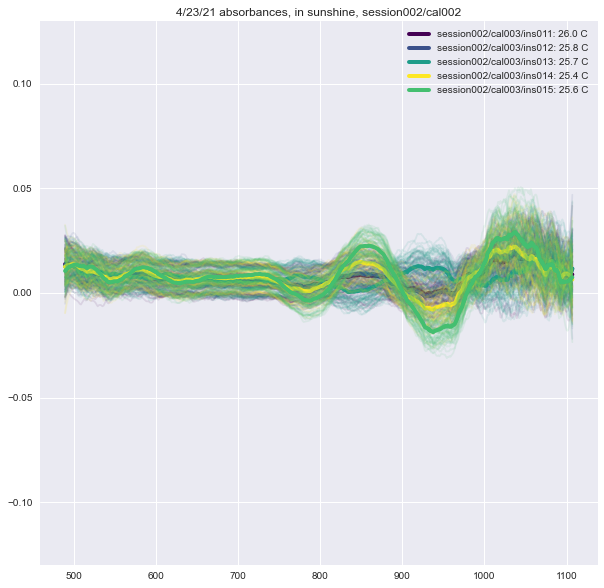

In [84]:
# compile a list of the insertions to plot
white_blank_ins = []
# append_session_insertion_strings(white_blank_ins, 'session001/cal001', 1, 7)
# append_session_insertion_strings(white_blank_ins, 'session001/cal002', 8, 8)
# append_session_insertion_strings(white_blank_ins, 'session001/cal002', 10, 14)
# append_session_insertion_strings(white_blank_ins, 'session002/cal001', 1, 5)
# append_session_insertion_strings(white_blank_ins, 'session002/cal002', 6, 10)
append_session_insertion_strings(white_blank_ins, 'session002/cal003', 11, 15)
# append_session_insertion_strings(white_blank_ins, 'session002/cal004', 16, 20)

# Get temperatures for the insertion and find min and max temps
insertion_temps = []
for insertion in white_blank_ins:    
    insertion_temp = get_insertion_temperature(file, insertion)
    insertion_temps.append(insertion_temp)
temp_min = min(insertion_temps)
temp_max = max(insertion_temps)

# plot raw means for each insertion, color determined by temperature
fig, ax = plt.subplots(figsize=(10, 10))
# ax.set_xlim(1100, 2400)
ax.set_ylim(-0.13, 0.13)
ax.set_title("4/23/21 absorbances, in sunshine, session002/cal002")

for insertion in white_blank_ins:    
    insertion_temp = get_insertion_temperature(file, insertion)
    color = plt.cm.viridis((insertion_temp - temp_max)/(temp_min - temp_max))
    ins_raw = get_visible_insertion_absorbances(file, insertion)
    ftir_waves = get_visible_wavelength_vector(file, calibration)
    ax.plot(ftir_waves, savgol_filter(ins_raw.mean(axis=0), 21, 3), color=color, lw=4, label=f'{insertion}: {insertion_temp:0.1f} C')
    for i in range(ins_raw.shape[0]):
        ax.plot(ftir_waves, savgol_filter(ins_raw[i, :], 21, 3), color=color, alpha=0.1)
ax.legend()
plt.show()
plt.close()

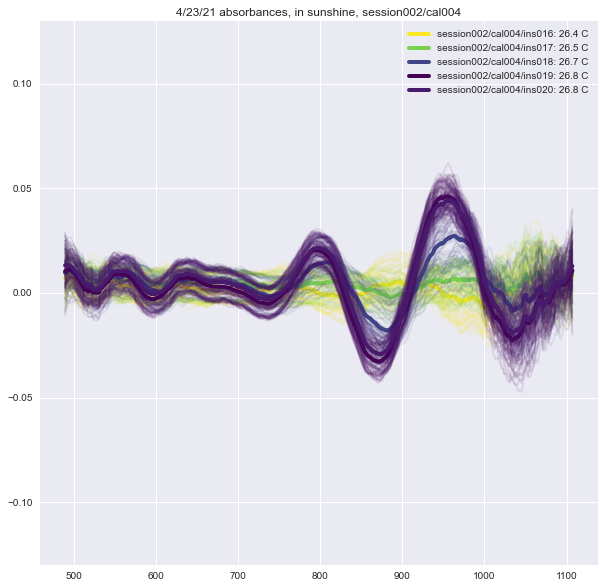

In [85]:
# compile a list of the insertions to plot
white_blank_ins = []
# append_session_insertion_strings(white_blank_ins, 'session001/cal001', 1, 7)
# append_session_insertion_strings(white_blank_ins, 'session001/cal002', 8, 8)
# append_session_insertion_strings(white_blank_ins, 'session001/cal002', 10, 14)
# append_session_insertion_strings(white_blank_ins, 'session002/cal001', 1, 5)
# append_session_insertion_strings(white_blank_ins, 'session002/cal002', 6, 10)
# append_session_insertion_strings(white_blank_ins, 'session002/cal003', 11, 15)
append_session_insertion_strings(white_blank_ins, 'session002/cal004', 16, 20)

# Get temperatures for the insertion and find min and max temps
insertion_temps = []
for insertion in white_blank_ins:    
    insertion_temp = get_insertion_temperature(file, insertion)
    insertion_temps.append(insertion_temp)
temp_min = min(insertion_temps)
temp_max = max(insertion_temps)

# plot raw means for each insertion, color determined by temperature
fig, ax = plt.subplots(figsize=(10, 10))
# ax.set_xlim(1100, 2400)
ax.set_ylim(-0.13, 0.13)
ax.set_title("4/23/21 absorbances, in sunshine, session002/cal004")

for insertion in white_blank_ins:    
    insertion_temp = get_insertion_temperature(file, insertion)
    color = plt.cm.viridis((insertion_temp - temp_max)/(temp_min - temp_max))
    ins_raw = get_visible_insertion_absorbances(file, insertion)
    ftir_waves = get_visible_wavelength_vector(file, calibration)
    ax.plot(ftir_waves, savgol_filter(ins_raw.mean(axis=0), 21, 3), color=color, lw=4, label=f'{insertion}: {insertion_temp:0.1f} C')
    for i in range(ins_raw.shape[0]):
        ax.plot(ftir_waves, savgol_filter(ins_raw[i, :], 21, 3), color=color, alpha=0.1)
ax.legend()
plt.show()
plt.close()